# Opportunistic Cost-Aware Feature Aquisition

In [19]:
import pdb
import os
import copy
import time
import pickle
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython import display
import sklearn.feature_selection

import nhanes
from DataGenerator import DataGenerator
import src.utils as utils
os.environ['CUDA_VISIBLE_DEVICES'] = ''
torch.set_num_threads(2)

UTILTY = 'Bayesian-L1' # 'sotfmax', 'Bayesian-MAX', 'Bayesian-L1', 'Bayesian-L2'
DATASET =  'diabetes' # 'diabetes'
EXPERIMENT_NAME = 'mTurk'
UNIFORM_COST = False
SHARE_PQ = True
GAMMA = 0.00
AL_STRATEGY = 'OL'
LABEL_RATIO = 1.0

RUN_OUTPUTS_PATH = './run_outputs/'
DATA_PATH = '/home/mohammad/Database/CDC/NHANES/'

In [2]:
# get start time
time_start = time.time()
print('Process Started at:', time_start)

# load magics
%load_ext autoreload
%autoreload 2
%matplotlib inline

# define experiment name
EXPERIMENT = DATASET + '_' + UTILTY + '_' + EXPERIMENT_NAME

# create directories
os.makedirs(os.path.dirname(RUN_OUTPUTS_PATH), exist_ok=True)
os.makedirs(os.path.dirname(RUN_OUTPUTS_PATH + '/trace_files/'), exist_ok=True)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Process Started at: 1550194817.4889326
Using device: cpu


## Experiment Setup

In [3]:
if DATASET == 'diabetes':
    ds = nhanes.Dataset(DATA_PATH)
    ds.load_diabetes()
    n_fe = ds.features.shape[1]
    dataset_costs = ds.costs.reshape(1,-1)
    generator_trn = DataGenerator(ds.get_dataset('train'))
    generator_val = DataGenerator(ds.get_dataset('validation'))
    generator_tst = DataGenerator(ds.get_dataset('test'))
    # settings
    architecture = {'n_features':n_fe, 'n_classes':3, 'n_hiddens':[64,32,16]}
    N_EPISODES = 40000
else:
    raise NotImplementedError
    
# log setups
with open(RUN_OUTPUTS_PATH + EXPERIMENT + '_info.txt', 'w') as f:
    f.writelines([EXPERIMENT, '\n', str(architecture), '\n', 'N_EPISODES: '+str(N_EPISODES)])

# intialize the buffer
exp_buffer = utils.ExperienceBuffer(buffer_size=n_fe*1000)

if UNIFORM_COST:
    dataset_costs /= dataset_costs

architecture['share_pq'] = SHARE_PQ

dataset_costs

Processing: RXQ_RX_H.XPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Processing: BPQ_B.XPTXPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

array([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4]])

In [4]:
ds.features.shape

(92062, 45)

## Network Definition

In [5]:
class DPQN(nn.Module):
    def __init__(self, architecture, device):
        super(DPQN, self).__init__()
        
        # set attributes
        self.device = device
        self.n_features = architecture['n_features']
        self.n_classes = architecture['n_classes']
        self.n_hiddens = architecture['n_hiddens']
        self.share_pq = architecture['share_pq']
        self.layers_p = nn.ModuleList()
        self.layers_q = nn.ModuleList()
        
        # initialize the P-Net
        size_last = self.n_features
        for n_h in self.n_hiddens+[self.n_classes]:
            self.layers_p.append(nn.Linear(size_last, n_h))
            size_last = n_h
        
        # initialize the Q-Net
        size_last = self.n_features
        if self.share_pq:
            #self.n_hiddens_q = [n_h//4 for n_h in self.n_hiddens]
            self.n_hiddens_q = []
            for ind in range(len(self.n_hiddens)):
                if ind == 0:
                    self.n_hiddens_q.append(self.n_hiddens[ind])
                else:
                    n_h = (self.n_hiddens[ind-1]*self.n_hiddens[ind]) \
                            // (self.n_hiddens[ind-1]+self.n_hiddens_q[-1])
                    self.n_hiddens_q.append(n_h)
            for (n_h,n_h_q) in zip(self.n_hiddens, self.n_hiddens_q):
                self.layers_q.append(nn.Linear(size_last, n_h_q))
                size_last = n_h + n_h_q
            self.layers_q.append(nn.Linear(size_last, self.n_features+1))
        else:
            self.n_hiddens_q = self.n_hiddens
            for n_h in self.n_hiddens_q+[self.n_features+1]:
                self.layers_q.append(nn.Linear(size_last, n_h))
                size_last = n_h  
        
        
    def forward(self, x, mode='P', costs=None):
        """
            P: if we only need to make prediction
        """
        output_dict = {}
        if type(x) == np.ndarray:
            x = torch.from_numpy(x).to(
                device=self.device, dtype=torch.float32, non_blocking=True)
        elif type(x) == list:
            x = torch.from_numpy(np.array(x)).to(
                device=self.device, dtype=torch.float32, non_blocking=True)
        else:
            x = x.to(device=self.device, dtype=torch.float32, non_blocking=True)
        
        nan_mask = torch.isnan(x)
        #x[nan_mask] = 0.0
        #if mode == 'Q':
        #    pdb.set_trace()
        #x *= (~nan_mask).type(torch.float32)
        x.masked_fill_(nan_mask, 0.0)
        
        # P-Net forward path
        if mode in ['P', 'PQ'] or self.share_pq:
            act_last = x
            acts_p = []
            # hidden layers with dropout
            for f_layer in self.layers_p[:-1]:
                act_last = F.dropout(F.relu(f_layer(act_last)), training=True)
                acts_p.append(act_last)
            # output layer
            op = self.layers_p[-1](act_last)
            op_prob = F.softmax(op, dim=1)
            pred_prob, pred_p = torch.max(op_prob, dim=1)
            output_dict['op'] = op
            output_dict['op_prob'] = op_prob
            output_dict['pred_prob'] = pred_prob
            output_dict['pred_p'] = pred_p
        
        
        # Q-Net forward path
        if mode in ['Q', 'PQ']:
            act_last = x
            # hidden layers with dropout
            act_last = F.relu(self.layers_q[0](act_last))
            if self.share_pq:
                for (f_layer,p_act) in zip(self.layers_q[1:-1], acts_p[:-1]):
                    p_act = p_act.detach()
                    act_last = F.relu(f_layer(torch.cat([act_last, p_act], dim=1)))
                # output layer
                p_act = acts_p[-1].detach()
                oq = self.layers_q[-1](torch.cat([act_last, p_act], dim=1))
            else:
                for f_layer in self.layers_q[1:-1]:
                    act_last = F.relu(f_layer(act_last))
                # output layer
                oq = self.layers_q[-1](act_last)
            #oq = F.pad(oq, (0,1), mode='constant', value=np.nan)
            # filter output layer
            oq_a_vaild = oq.clone()
            #actn_mask = F.pad(nan_mask, (0,1), mode='constant', value=1.0)
            actn_mask = nan_mask.new_empty(*oq_a_vaild.shape)
            actn_mask[:,:-1] = nan_mask
            actn_mask[:,-1] = 1.0
            #oq_a_vaild[~actn_mask] = -1.0e30
            oq_a_vaild.masked_fill_(~actn_mask, -1.0e30)
            oq_a_vaild[:,-1] = -1.0e20
            # consider cost weightings
            if type(costs) != type(None):
                if type(costs) == np.ndarray:
                    costs = torch.from_numpy(costs).to(
                        device=self.device, dtype=torch.float32, non_blocking=True)
                oq_a_vaild[:,:-1] /= costs
            _, pred_q = torch.max(oq_a_vaild, dim=1)
            output_dict['oq'] = oq
            output_dict['pred_q'] = pred_q
            
        return output_dict
    

    def update(self, model_x, update_rate=1.0):
        """
        update weights from another model.
        update rate: controls how smooth is the update.
        """ 
        for target_param, param in zip(self.parameters(), model_x.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - update_rate) + param.data * update_rate)
        
    def confidence(self, x, mcdrop_samples=1):
        """
        calculate the confidence historgram for each class given a sample.
        x: input sample
        mcdrop_samples: mc dropout samples to use
        """
        if type(x) == np.ndarray:
            x = torch.from_numpy(x).to(device=self.device, dtype=torch.float32, non_blocking=True)
        else:
            x = x.to(device=self.device, dtype=torch.float32, non_blocking=True)
        x_rep = x.expand(mcdrop_samples,-1)
        y_probs = self.forward(x_rep, mode='P')['op_prob']
        return y_probs.mean(dim=0)
    
    def predict(self, x, mcdrop_samples=1):
        """
        make class prediction for a sample.
        x: input sample
        mcdrop_samples: mc dropout samples to use
        """
        conf = self.confidence(x, mcdrop_samples)
        pred = torch.argmax(conf)
        return pred

## Reward Function

In [6]:
def calc_reward(conf_a, conf_b, method):
    if method == 'softmax':
        reward = torch.abs(conf_a.max() - conf_b.max())
    elif method == 'Bayesian-L1':
        reward = torch.abs(conf_a - conf_b).sum()
    elif method == 'Bayesian-L2':
        reward = ((conf_a - conf_b) ** 2.0).sum()
    else:
        raise NotImplementedError('Method is not supported:', method)
    return reward.item()

In [7]:
ds.features.std(0)

array([0.99999457, 0.99999457, 0.22675892, 0.18709346, 0.307203  ,
       0.26642292, 0.18854062, 0.12072905, 0.42018786, 0.27311812,
       0.48343873, 0.42327995, 0.27676439, 0.99999457, 0.99999457,
       0.99999457, 0.99999457, 0.99999457, 0.99999457, 0.99999457,
       0.99999457, 0.99999457, 0.99999457, 0.99999457, 0.99999457,
       0.99999457, 0.99999457, 0.99999457, 0.99999457, 0.99999457,
       0.99999457, 0.99999457, 0.99999457, 0.99999457, 0.99999457,
       0.99999457, 0.99999457, 0.99999457, 0.43151298, 0.45665412,
       0.01398149, 0.02083989, 0.99999457, 0.99999457, 0.99999457])

## Active Learning Strategies

In [8]:
class ActiveLearningStrategy:
    def __init__(self, strategy, label_ratio):
        self.strategy = strategy
        self.label_ratio = label_ratio
        # run time setups
        self.label_cnt = 0
        self.active_budget = 0.0
        self.active_window = 200.0
        # other strategy specific params
        self.active_theta = 1.0
        self.prob_rand_min = 0.1
        self.active_step = 0.05

    def decide(self, conf):
        label_flag = False
        
        # if AL is not to be used
        if self.label_ratio == 1.0:
            label_flag = True
        
        # random labeling
        elif self.strategy == 'Rand':
            if self.active_budget < self.label_ratio:
                if np.random.rand() < 0.5:
                    label_flag = True     
                    
        # variable uncertainty labeling
        elif self.strategy == 'VarUn':
            if self.active_budget < self.label_ratio:
                if conf < self.active_theta:
                    self.active_theta -= self.active_step
                    label_flag = True
                else:
                    self.active_theta += self.active_step

        # split labeling
        elif self.strategy == 'Split':
            if self.active_budget < self.label_ratio:
                # if it is random labeling
                if np.random.rand() < self.prob_rand_min:
                    label_flag = True
                else:
                    if conf < self.active_theta:
                        self.active_theta -= self.active_step
                        label_flag = True
                    else:
                        self.active_theta += self.active_step
                    
        # opportunistic labeling
        elif self.strategy == 'OL':
            if self.active_budget < self.label_ratio:
                # if it is random labeling
                label_prob = self.prob_rand_min / (self.prob_rand_min + conf)
                if np.random.rand() < label_prob:
                    label_flag = True
                else:
                    if conf < np.tanh(self.active_theta):
                        self.active_theta -= self.active_step
                        label_flag = True
                    else:
                        self.active_theta += self.active_step
        
        # if the sample is to be labeled
        if label_flag:
            self.label_cnt += 1
            # update budget values
            self.active_budget = self.active_budget * \
                    (self.active_window-1)/self.active_window + 1/self.active_window
        else:
            # update budget values
            self.active_budget = self.active_budget * \
                    (self.active_window-1)/self.active_window + 0.0
        
        return label_flag
    

In [9]:
# acrtive learning strategy
al_strategy = ActiveLearningStrategy(strategy=AL_STRATEGY, 
                                     label_ratio=LABEL_RATIO)

# instantiate networks
current_model = DPQN(architecture, device=device).to(device)
target_model = DPQN(architecture, device=device).to(device)
target_model.update(current_model)

# define loss functions
loss_fn_p = nn.CrossEntropyLoss()
loss_fn_q = nn.MSELoss()

# create an optimizer
lr_current = 1.0e-3
optimizer = optim.Adam(current_model.parameters(), lr=lr_current)

Playing Episode:  39900/40000 | Iter:  1304716 | Phase:  Q | Time:  311 m, 42 s, eps: 1.8016106769816593
Buffer:  45000 / 45000 , prob_rand:  0.12661932675095416
 loss_trn_p:  1.0214176177978516 , loss_trn_q:  6.461485385894775
 accus_val:  0.794921875 , costs_val:  185.0 , actions_val:  46.0
 label_cnt: 39901 , active_budget 0.9999999999999784 , active_theta 1.0


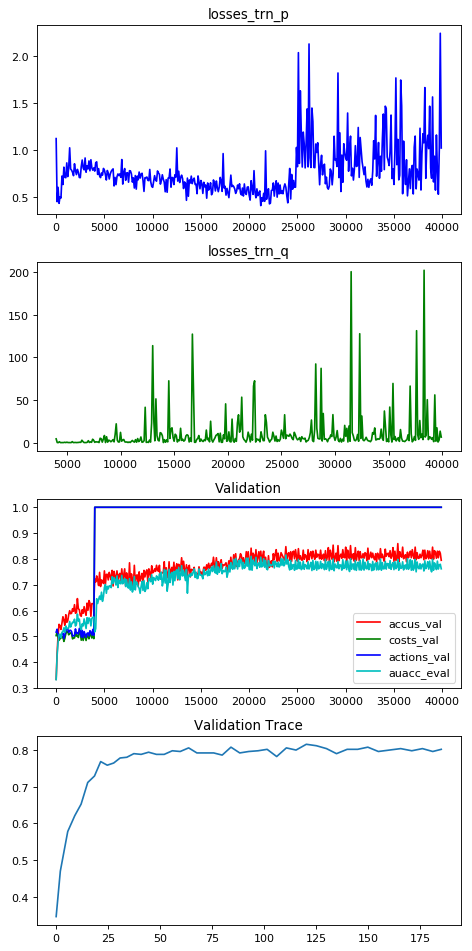

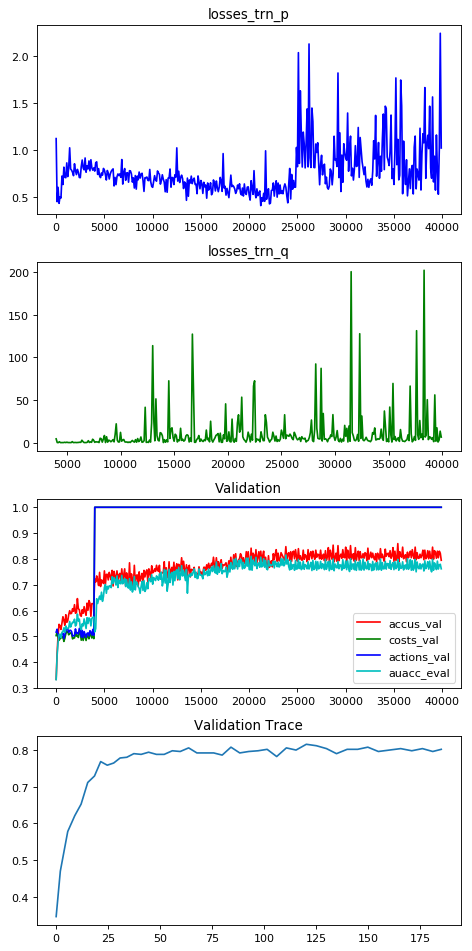

In [10]:
#%%prun

#N_EPISODES=1000
#def profile_me(N_EPISODES=1000):
if True:
    time_tick = time.time()
    prob_rand = 1.0
    prob_rand_min = 0.1
    prob_rand_deacy = np.exp(np.log(0.1)/N_EPISODES)
    gamma = GAMMA
    batch_size = 128
    batch_size_val = 512
    mc_samples = 100 # would be mcmc_samples//10 for prediction
    iter_per_exp = n_fe//100 + 1
    
    # append one element per validation:
    val_episodes = []
    val_iters = []
    val_label_cnts = []
    trn_losses_p = []
    trn_losses_q = []
    accus_eval = []
    costs_eval = []
    actions_eval = []
    auacc_eval = []
    # append one per validation sample
    actions_log = []
    
    exp_cnt = 0
    iter_trn = 0
    phase = 'P'
    for episode_cnt in range(N_EPISODES):
        
        ##-------- handle phases
        progress_pct = 100 * episode_cnt // N_EPISODES
        if episode_cnt == N_EPISODES//10:
            phase = 'Q'
        elif episode_cnt > N_EPISODES//10:
            # decay random action probability
            prob_rand = max(prob_rand_min, prob_rand*prob_rand_deacy)
        ##-------- adaptive learning rate 
        if progress_pct >= 60 and progress_pct%20 == 0:
            lr_current /= 10
            optimizer = optim.Adam(current_model.parameters(), lr=lr_current)
        ##-------- get a new sample
        sample = generator_trn.get_data_point()
        s = sample.get_features().reshape(1,-1)
        conf = current_model.confidence(s, mc_samples)
        
        ##-------- play the episode
        active_exp_buffer = []
        term_flag = False
        while not term_flag:
            exp_cnt += 1
            # based on p do a random or q* action
            if np.random.random() < prob_rand:
                valid_acts = np.argwhere(np.isnan(s.ravel()))
                valid_acts = np.append(valid_acts, [current_model.n_features])
                #probs = np.ones_like(valid_acts, dtype=np.float32)
                #if phase == 'P':
                #    probs[-1] = probs[-1] #/ 10.0
                #probs = probs / probs.sum()
                #a = np.random.choice(valid_acts, size=None, p=probs)
                a = np.random.choice(valid_acts, size=None)
            # if Q_Net is selecting actions
            else:
                a = target_model.forward(s, costs=dataset_costs, mode='Q')['pred_q']
                a = a.item()
            # if it is feature query 
            if a < current_model.n_features:
                s1 = sample.request_feature(a).reshape(1,-1)
                conf1 = current_model.confidence(s1, mc_samples)
                r = calc_reward(conf, conf1, method=UTILTY)
            # if it is pred action
            elif a == current_model.n_features:
                term_flag = True
                r = 0.0
            # push the new exp into the buffer
            y = sample.request_label()
            active_exp_buffer.append((s, r, a, s1, y))
            s = s1
            conf = conf1
            
            ##-------- active labeling
            if term_flag:
                label_flag = al_strategy.decide(conf.max().item())
                # if the sample is to be labeled
                if label_flag:
                    for exp in active_exp_buffer:
                        exp_buffer.push(exp)
            
            ##-------- train the model
            if ((len(exp_buffer.buffer)<1*batch_size) \
                    or not (exp_cnt%iter_per_exp==0)) \
                    and not (episode_cnt%100==0 and term_flag):
                continue
            else:
                iter_trn += 1
            # prepare inputs
            samples_trn = exp_buffer.sample(batch_size)
            samples_trn_s0 = [s[0].ravel() for s in samples_trn]
            samples_trn_r = [s[1] for s in samples_trn]
            samples_trn_a = [s[2] for s in samples_trn]
            samples_trn_s1 = [s[3].ravel() for s in samples_trn]
            samples_trn_y = [s[4] for s in samples_trn]
            # update the P-Net
            if phase == 'P' or phase == 'Q':
                y_logits = current_model.forward(samples_trn_s0, 'P')['op']
                samples_trn_y = torch.from_numpy(
                    np.array(samples_trn_y)).to(device=device, dtype=torch.long, non_blocking=True)
                loss_p = loss_fn_p(y_logits, samples_trn_y)
                optimizer.zero_grad()
                loss_p.backward()
                optimizer.step()
                loss_q = torch.tensor([np.nan]).to(device) # for logging purposes
            else:
                NotImplementedError('Unsupported phase!')
            # update the Q-Net
            if phase == 'Q':
                # |r+gamma*Q_target(s1, a':argmax(Q(s1,a'))) - Q(s0,a)|
                # the term using the current network
                oq = current_model.forward(samples_trn_s0, 'Q')['oq']
                oq_pred = oq.gather(1, torch.from_numpy(
                            np.array(samples_trn_a)).to(
                    device=device, dtype=torch.long, non_blocking=True).view(-1,1))
                # the double-q target term
                oa_double = current_model.forward(samples_trn_s1, 'Q')['pred_q']
                oq_double = target_model.forward(samples_trn_s1, 'Q')['oq']
                oq_double = oq_double.gather(1, torch.from_numpy(
                            np.array(oa_double)).to(
                                device=device, dtype=torch.long, non_blocking=True).view(-1,1))
                oq_target = torch.from_numpy(np.array(
                            samples_trn_r)).view(-1,1).to(
                            device=device, dtype=torch.float32, non_blocking=True) + \
                            gamma * oq_double
                oq_target_nograd = oq_target.detach()
                loss_q = loss_fn_q(oq_pred, oq_target_nograd)
                optimizer.zero_grad()
                loss_q.backward()
                optimizer.step()
                
            # update the target model the from current model
            target_model.update(current_model, 0.001)
            
            ##-------- validate the model
            if episode_cnt%100==0 and term_flag:
                # append the current validation episode and iter
                val_episodes.append(episode_cnt)
                val_iters.append(iter_trn)
                val_label_cnts.append(al_strategy.label_cnt)
                # append train the set loss for p and q
                loss_p = loss_p.item()
                loss_q = loss_q.item()
                trn_losses_p.append(loss_p)
                trn_losses_q.append(loss_q)
                
                # validate for each sample
                actns_val = []
                costs_val = []
                accus_val = []
                trace_val = np.zeros((batch_size_val,2,n_fe+1), 
                                     dtype=np.float) - 1.0 # 0:cost, 1:accuracy
                for ind_sa in range(batch_size_val):
                    actn_cnt_val = 0
                    cost_val = 0
                    acts_val = []
                    # get a sample
                    sample_val = generator_val.get_data_point()
                    s_val = sample_val.get_features().reshape(1,-1)
                    y_val = sample_val.request_label()
                    # while it is not the terminate action
                    term_flag_val = False
                    while not term_flag_val:
                        # make a prediction using the current state
                        pred_val = current_model.predict(s_val, mc_samples//10).item()
                        if pred_val == y_val:
                            accu_val = 1.0
                        else:
                            accu_val = 0.0
                        # store trace info
                        trace_val[ind_sa, 0, int(actn_cnt_val)] = cost_val
                        trace_val[ind_sa, 1, int(actn_cnt_val)] = accu_val

                        actn_cnt_val += 1
                        
                        # take an action
                        # if phase is P, take a random action
                        if phase == 'P':
                            valid_acts = np.argwhere(np.isnan(s_val.ravel()))
                            valid_acts = np.append(valid_acts, [current_model.n_features])
                            a_val = np.random.choice(valid_acts, size=None)
                        # if the phase is Q, Q-Net will decide
                        else:
                            a_val = target_model.forward(s_val, 
                                                         costs=dataset_costs, 
                                                         mode='Q')['pred_q'].item()
                            #pdb.set_trace()
                        # if it is feature query 
                        if a_val < current_model.n_features:
                            s_val = sample_val.request_feature(a_val).reshape(1,-1)
                            cost_val += sample_val.get_feature_costs()[a_val]
                        # if it is pred action
                        elif a_val == current_model.n_features:
                            term_flag_val = True
                            pred_val = current_model.predict(s_val, mc_samples//10).item()
                            if pred_val == y_val:
                                accu_val = 1.0
                            else:
                                accu_val = 0.0
                        else:
                            raise NotImplementedError
                        
                        acts_val.append(a_val)
                    
                    actns_val.append(actn_cnt_val)
                    costs_val.append(cost_val)
                    accus_val.append(accu_val)
                    # put plateau values
                    trace_val[ind_sa, 0, int(actn_cnt_val):] = cost_val
                    trace_val[ind_sa, 1, int(actn_cnt_val):] = accu_val
                    # reduce memory usage by storing actions on the first sample
                    if True:#ind_sa == 0:
                        actions_log.append(acts_val)

                accus_eval.append(np.mean(accus_val))    
                costs_eval.append(np.mean(costs_val))
                actions_eval.append(np.mean(actns_val))
                cost_trace = trace_val.mean(axis=0)[0]
                accu_trace = trace_val.mean(axis=0)[1]
                auacc_eval.append(accu_trace.sum() / accu_trace.shape[0])
                elaplsed_time_s = int((time.time() - time_start)%60)
                elaplsed_time_m = int((time.time() - time_start)//60)
                elaplsed_time_eps = 100 / (time.time()-time_tick)
                time_tick = time.time()
                # display stats
                plt.close('all')
                display.clear_output(wait=True)
                fig=plt.figure(figsize=(6, 12), dpi= 80, facecolor='w', edgecolor='k')
                plt.subplot(4,1,1)
                plt.plot(val_episodes[:], trn_losses_p[:], 'b')
                plt.title('losses_trn_p')
                plt.subplot(4,1,2)
                plt.plot(val_episodes[:], trn_losses_q[:], 'g')
                plt.title('losses_trn_q')
                plt.subplot(4,1,3)
                plt.plot(val_episodes[:], accus_eval[:], 'r')
                plt.plot(val_episodes[:], np.array(costs_eval)/np.max(costs_eval), 'g')
                plt.plot(val_episodes[:], np.array(actions_eval)/np.max(actions_eval), 'b')
                plt.plot(val_episodes[:], auacc_eval, 'c')
                plt.legend(['accus_val','costs_val','actions_val', 'auacc_eval'])
                plt.title('Validation')
                plt.subplot(4,1,4)
                plt.plot(cost_trace, accu_trace)
                plt.title('Validation Trace')
                
                plt.tight_layout()
                print('Playing Episode: ', str(episode_cnt)+'/'+str(N_EPISODES), 
                  '| Iter: ', str(iter_trn), '| Phase: ', phase, '| Time: ', 
                     elaplsed_time_m, 'm,', elaplsed_time_s, 's, eps:', elaplsed_time_eps)
                print('Buffer: ', len(exp_buffer.buffer), '/', exp_buffer.buffer_size, 
                      ', prob_rand: ', prob_rand)            
                print(' loss_trn_p: ', loss_p, 
                      ', loss_trn_q: ', loss_q)
                print(' accus_val: ', accus_eval[-1], 
                      ', costs_val: ', costs_eval[-1], 
                      ', actions_val: ', actions_eval[-1])
                print(' label_cnt:', al_strategy.label_cnt, 
                      ', active_budget', al_strategy.active_budget, 
                      ', active_theta', al_strategy.active_theta)
                display.display(plt.gcf())

    plt.savefig(RUN_OUTPUTS_PATH + EXPERIMENT + '_curve.pdf')
    
#%lprun -f current_model.forward profile_me()
#%lprun -f current_model.confidence profile_me()
#%lprun -f current_model.update profile_me()
#%lprun -f profile_me profile_me()


## Visualize the acquistion order

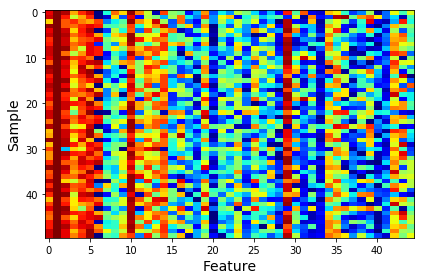

In [11]:
sel_action_logs = actions_log[-50:]
orders = np.zeros((len(sel_action_logs), n_fe+1), dtype=np.float) - 1.0

for i in range(orders.shape[0]):
    cnt = 0
    for a in sel_action_logs[i]:
        cnt += 1
        orders[i][a] = cnt
orders[orders==-1] = np.nan
#orders[orders>16] = np.nan
orders = 65 - orders
cmap = copy.copy(plt.cm.get_cmap('jet')) 
cmap.set_bad(alpha=0.0)
fig=plt.figure()#figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(orders[:,:-1], cmap=cmap, 
           interpolation='nearest', aspect='auto')
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Sample', fontsize=14)
plt.tight_layout()
plt.savefig(RUN_OUTPUTS_PATH + EXPERIMENT + '_order.pdf')

## Compare experiments

Running Experiment: OL
Running Experiment: Rand
Running Experiment: lcf


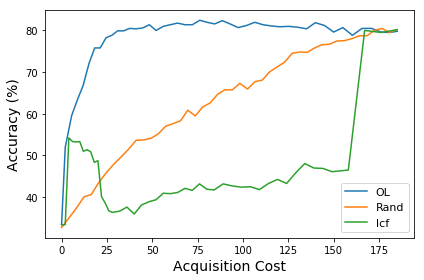

In [15]:
batch_size_tst = 1024
experiments = ['OL', 'Rand', 'lcf']
markers = ['D', 'x', '^', '>']
# generate samples
samples = [generator_tst.get_data_point() for _ in range(batch_size_tst)]


# run experiments
exp_traces = []
exp_traces_mean = []
for exp_tst in experiments:
    print('Running Experiment:', exp_tst)
    samples_tst = copy.deepcopy(samples)
    # 0:cost, 1:accuracy, 2:action, 3:conf
    trace_tst = np.zeros((batch_size_tst,4,n_fe+1), dtype=np.float) - 1.0 
    for ind_sa in range(batch_size_tst):
        # get a test sample
        actn_cnt_tst = 0
        cost_tst = 0
        actions_tst = []
        sample_tst = samples_tst[ind_sa]
        s_tst = sample_tst.get_features().reshape(1,-1)
        y_tst = sample_tst.request_label()
        # while it is not the terminate action
        term_flag_tst = False
        while not term_flag_tst:
            pred = current_model.predict(s_tst, mc_samples//10).item()
            if pred == y_tst:
                accu_tst = 1.0
            else:
                accu_tst = 0.0

            trace_tst[ind_sa, 0, int(actn_cnt_tst)] = cost_tst
            trace_tst[ind_sa, 1, int(actn_cnt_tst)] = accu_tst
            
            actn_cnt_tst += 1

            if exp_tst == 'Rand':
                valid_acts = np.argwhere(np.isnan(s_tst.ravel()))
                valid_acts = np.append(valid_acts, [current_model.n_features])
                probs = np.ones_like(valid_acts, dtype=np.float32)
                probs[-1] = probs[-1] / 1000.0
                probs = probs / probs.sum()
                a_tst = np.random.choice(valid_acts, size=None, p=probs)
            elif exp_tst == 'lcf':
                valid_acts = np.argwhere(np.isnan(s_tst.ravel()))
                acts_costs = dataset_costs.ravel()[valid_acts.ravel()]
                acts_costs = np.append(acts_costs, [1.0e+15])
                valid_acts = np.append(valid_acts, [current_model.n_features])
                a_tst = valid_acts[np.argsort(acts_costs)[0]]
            elif exp_tst == 'OL':
                a_tst = current_model.forward(s_tst, 
                             costs=dataset_costs, 
                             mode='Q')['pred_q'].item()
            else:
                raise NotImplementedError
            # if it is feature query 
            if a_tst < current_model.n_features:
                s_tst = sample_tst.request_feature(a_tst).reshape(1,-1)
                cost_tst += sample_tst.get_feature_costs()[a_tst]
                
            # if it is pred action
            elif a_tst == current_model.n_features:
                pred = current_model.predict(s_tst, mc_samples//10).item()
                if pred == y_tst:
                    accu_tst = 1.0
                else:
                    accu_tst = 0.0
                term_flag_tst = True
            else:
                raise NotImplementedError
            actions_tst.append(a_tst)
            trace_tst[ind_sa, 2, int(actn_cnt_tst)-1] = a_tst
            #trace_tst[ind_sa, 3, int(actn_cnt_tst)-1] = mc_probs.mean(axis=0).max()

        # put plateau values
        trace_tst[ind_sa, 0, int(actn_cnt_tst):] = cost_tst
        trace_tst[ind_sa, 1, int(actn_cnt_tst):] = accu_tst


    cost_trace = trace_tst.mean(axis=0)[0]
    accu_trace = trace_tst.mean(axis=0)[1]
    exp_traces_mean.append(trace_tst.mean(axis=0))
    exp_traces.append(trace_tst)

plt.figure()
for ind_exp, exp in enumerate(experiments):
#     plt.plot(exp_traces_mean[ind_exp][0][::2], 
#              100.0 * exp_traces_mean[ind_exp][1][::2], 
#              marker=markers[ind_exp])
    plt.plot(exp_traces_mean[ind_exp][0], 
         100.0 * exp_traces_mean[ind_exp][1])
plt.legend(experiments, fontsize=11)
plt.xlabel('Acquisition Cost', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.tight_layout()
plt.savefig(RUN_OUTPUTS_PATH + EXPERIMENT + '_comp.pdf')

## Certainty estimation accuracy

(array([2047., 2980., 4417., 4861., 5123., 5327., 4995., 4269., 4223.,
        8862.]),
 array([0.33501568, 0.40151412, 0.46801255, 0.53451098, 0.60100941,
        0.66750784, 0.73400627, 0.80050471, 0.86700314, 0.93350157,
        1.        ]),
 <a list of 10 Patch objects>)

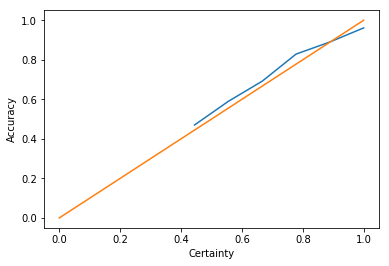

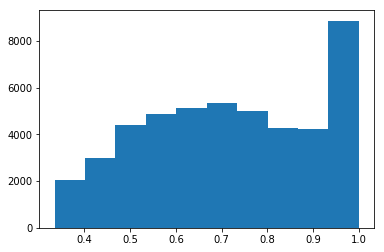

In [16]:
batch_size_val = 1024
mc_samples_val = mc_samples

# generate samples
samples = [generator_val.get_data_point() for _ in range(batch_size_val)]


# run experiments
confs = []
accus = []

samples_val = copy.deepcopy(samples)
# 0:cost, 1:accuracy, 2:action, 3:conf
trace_tst = np.zeros((batch_size_val,4,n_fe+1), dtype=np.float) - 1.0 
for ind_sa in range(batch_size_val):
    print('Processing ', ind_sa / batch_size_val, end='\r')
    # get a test sample
    actn_tst = 0
    cost_tst = 0
    actions_tst = []
    sample_tst = samples_val[ind_sa]
    s_tst = sample_tst.get_features().reshape(1,-1)
    y_tst = sample_tst.request_label()
    # while it is not the terminate action
    term_flag_tst = False
    while not term_flag_tst:
        conf = current_model.confidence(s_tst, mc_samples_val).max().item()
        pred = current_model.predict(s_tst, mc_samples_val).item()
        if pred == y_tst:
            accu_tst = 1.0
        else:
            accu_tst = 0.0

        trace_tst[ind_sa, 0, int(actn_tst)] = cost_tst
        trace_tst[ind_sa, 1, int(actn_tst)] = accu_tst

        actn_tst += 1
     
        a_tst = target_model.forward(s_tst, costs=dataset_costs, 
                                     mode='Q')['pred_q'].item()

        # if it is feature query 
        if a_tst < current_model.n_features:
            s_tst = sample_tst.request_feature(a_tst).reshape(1,-1)
            cost_tst += sample_tst.get_feature_costs()[a_tst]

        # if it is pred action        
        elif a_tst == current_model.n_features:
            pred = current_model.predict(s_tst, mc_samples_val).item()

            if pred == y_tst:
                accu_tst = 1.0
            else:
                accu_tst = 0.0
            term_flag_tst = True
        else:
            raise NotImplementedError
        
        confs.append(conf)
        accus.append(accu_tst)
        actions_tst.append(a_tst)
        trace_tst[ind_sa, 2, int(actn_tst)-1] = a_tst
        #trace_tst[ind_sa, 3, int(actn_tst)-1] = mcmc_probs.mean(axis=0).max()

    # put plateau values
    trace_tst[ind_sa, 0, int(actn_tst):] = cost_tst
    trace_tst[ind_sa, 1, int(actn_tst):] = accu_tst

#np.histogram(confs)
accus = np.array(accus)
bins = np.linspace(0.0,1.0,10)
conf_digits = np.digitize(confs, bins)
accu_at_bins = []
for ind_bin in range(len(bins)):
    if np.any(conf_digits==ind_bin):
        accu_at_bins.append(np.mean(accus[conf_digits==ind_bin]))
    else:
        accu_at_bins.append(np.nan)

plt.figure()
plt.plot(bins, accu_at_bins)
plt.plot(bins, bins)
plt.xlabel('Certainty')
plt.ylabel('Accuracy')
plt.figure()
plt.hist(confs)

## Store trace files

In [17]:
exp_trace = {}

exp_trace['EXP_VERSION'] = 'v1.0'
exp_trace['EXP_DATE'] = datetime.now().strftime('%Y/%m/%d %H:%M:%S')
exp_trace['EXP_METHOD'] = 'OL_DQN'
exp_trace['EXP_NAME'] = EXPERIMENT
exp_trace['EXP_ARCHITECTURE'] = architecture
exp_trace['LRN_EPISODES'] = val_episodes
exp_trace['LRN_AUACC'] = auacc_eval
exp_trace['LRN_LABELS'] = val_label_cnts
exp_trace['ACC_COST'] = exp_traces_mean[0][0,:]
exp_trace['ACC_ACCURACY'] = exp_traces_mean[0][1,:]
exp_trace['CONF_BINS'] = bins
exp_trace['CONF_ACCURACY'] = accu_at_bins
exp_trace['AL_STRATEGY'] = AL_STRATEGY
exp_trace['AL_BUDGET'] = LABEL_RATIO

with open(RUN_OUTPUTS_PATH+'trace_files/'+EXPERIMENT+'.pkl', 'ab+') as f:
    pickle.dump(exp_trace, f)
    
EXPERIMENT

'diabetes_Bayesian-L1_mTurk'